# **Diabetes Feature Engineering**

**Data Story**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies:Number of Pregnancy
* Glucose:2-hour plasma glucose concentration in the oral glucose tolerance test
* Blood Pressure:	Blood Pressure (Small Blood Pressure) (mmHg)
* SkinThicknessSkin:Thickness
* Insulin:2-hour serum insulin (mu U/ml)
* DiabetsPedigreeFunction:A function that calculates the probability of having diabetes according to one's descendants
* BMI: Body mass index
* Age: (Type: Year)
* Outcome:1 positive indicates does have diabetes, 0 indicates negative does not have diabetes.

In [ ]:
#!pip install missingno

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_ = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df = df_.copy()

In [ ]:
def data_review(dataframe):
    print("**********head**********")
    print(dataframe.head())
    print("**********isna**********")
    print(dataframe.isnull().sum())
    print("**********shape*********")
    print(dataframe.shape)
    print("*********info***********")
    print(dataframe.info())
    print("*********describe*******")
    print(dataframe.describe().T)
    print("*********nuniq*******")
    print(dataframe.nunique())

In [ ]:
data_review(df)

**********head**********
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
**********isna**********
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome      

In [ ]:
df['Glucose'] = df['Glucose'].replace(0,np.NaN)
df['Insulin'] = df['Insulin'].replace(0,np.NaN)
df['BMI'] = df['BMI'].replace(0,np.NaN)

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols , cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" ]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    
    return cat_cols, num_cols, cat_but_car


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
cat_but_car: 0
num_but_cat: 1


In [ ]:
cat_cols


['Outcome']

In [ ]:
num_cols


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

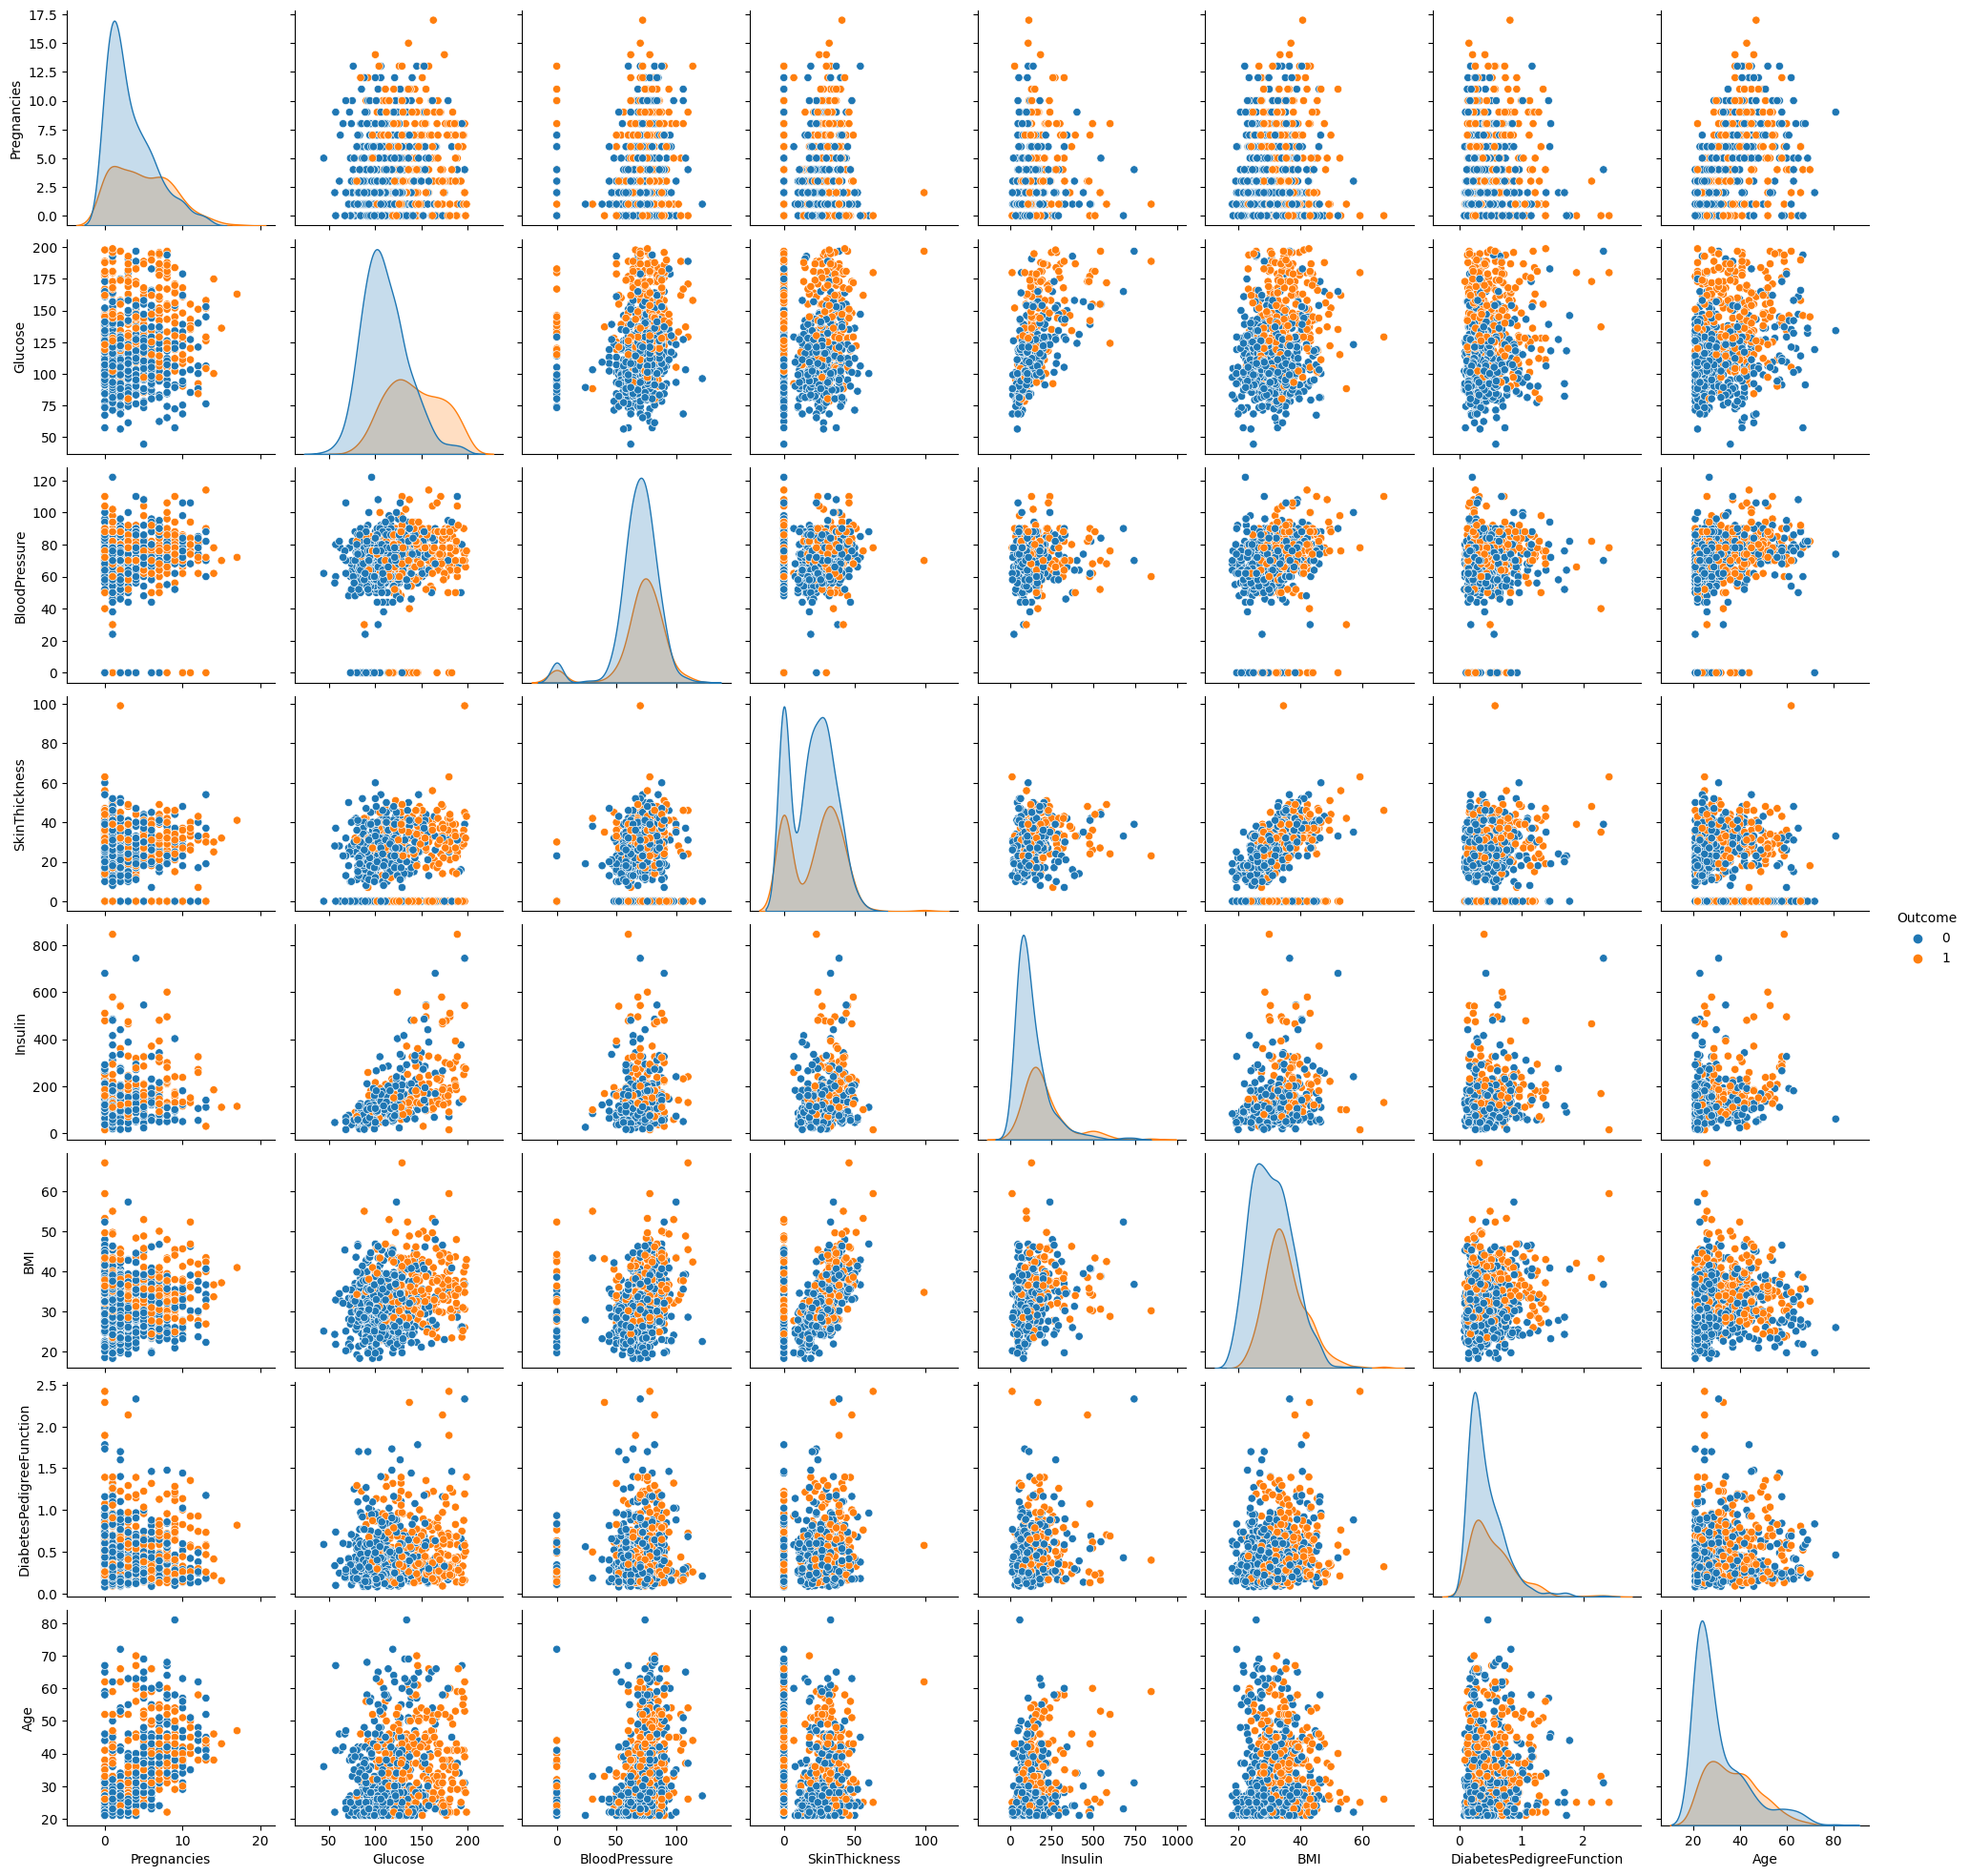

In [ ]:
sns.pairplot(df , hue='Outcome' , diag_kind = 'kde')

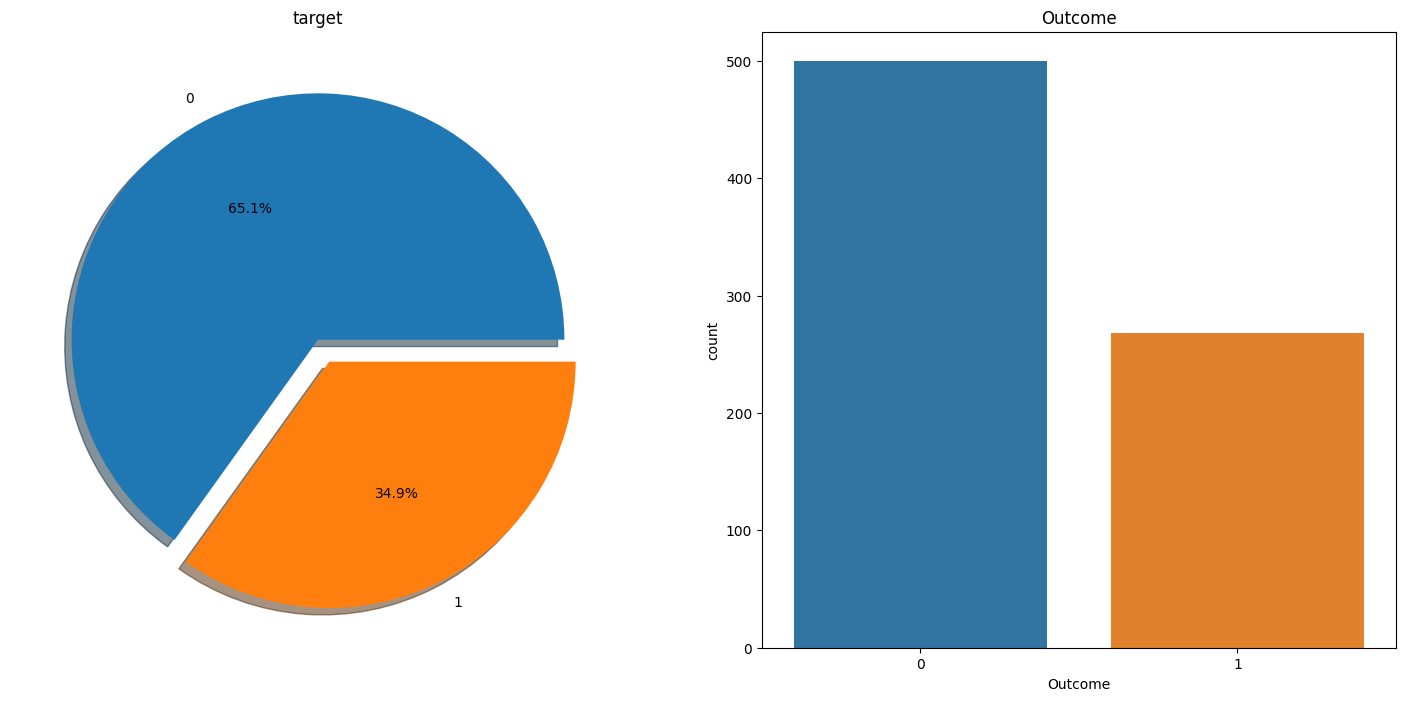

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Outcome'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot(x ='Outcome',data=df,ax=ax[1])
ax[1].set_title('Outcome')
plt.show()

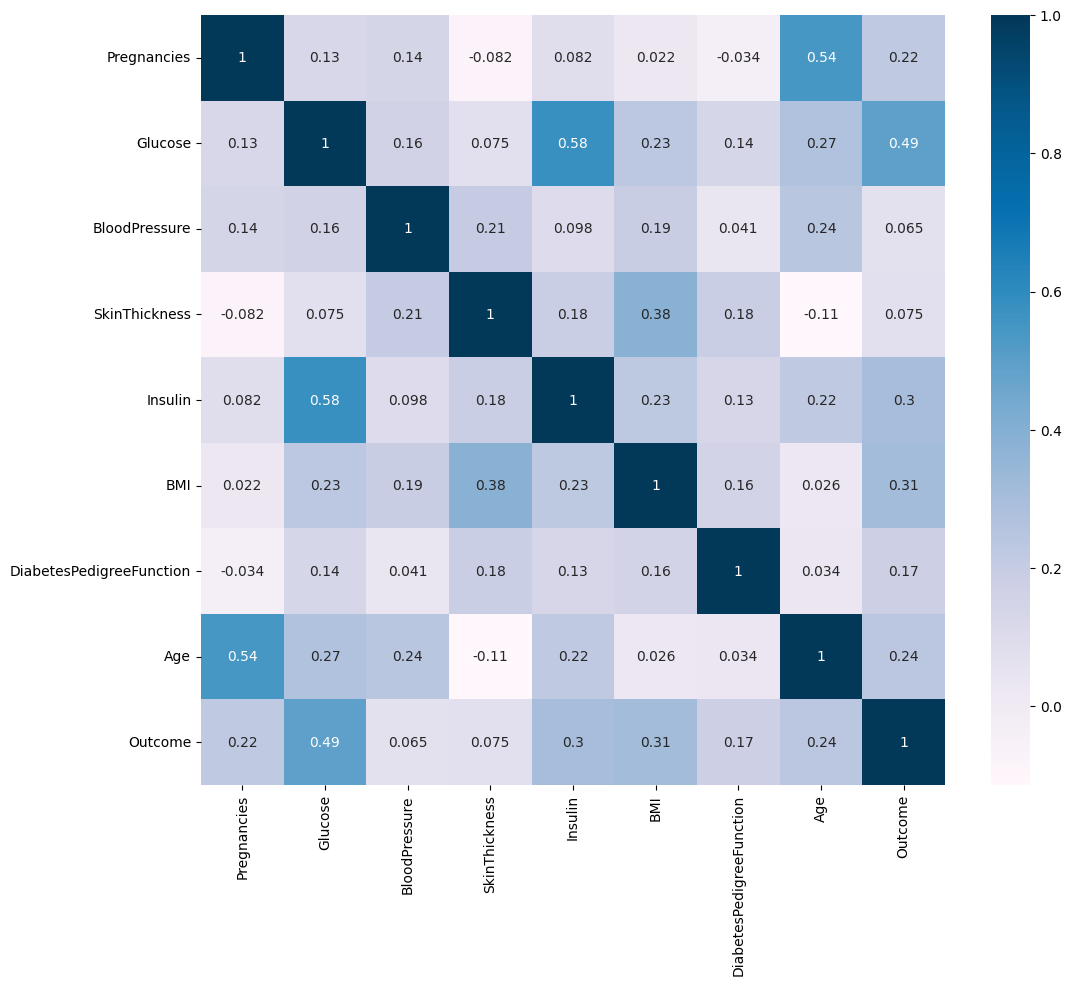

In [ ]:
plt.figure(figsize=(12,10))  
p=sns.heatmap(df.corr(), annot=True,cmap =plt.cm.PuBu)

In [ ]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
check_outlier(df, "Insulin")

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


True

In [ ]:
outlier_thresholds(df, "Insulin")
replace_with_thresholds(df, "Insulin")
outlier_thresholds(df, "DiabetesPedigreeFunction")
replace_with_thresholds(df, "DiabetesPedigreeFunction")
outlier_thresholds(df, "SkinThickness")
replace_with_thresholds(df, "SkinThickness")
outlier_thresholds(df, "Pregnancies")
replace_with_thresholds(df, "Pregnancies")
outlier_thresholds(df, "Glucose")
replace_with_thresholds(df, "Glucose")
outlier_thresholds(df, "BloodPressure")
replace_with_thresholds(df, "BloodPressure")
outlier_thresholds(df, "BMI")
replace_with_thresholds(df, "BMI")
outlier_thresholds(df, "Age")
replace_with_thresholds(df, "Age")

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/tmp/ipykernel_13/1428178594.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computa

In [ ]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                 0
SkinThickness                 0
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
M_BMI = df['BMI'].median()
df['BMI'] = df['BMI'].fillna(M_BMI)
M_INS = df['Insulin'].median()
df['Insulin'] = df['Insulin'].fillna(M_INS)
M_GLU = df['Glucose'].median()
df['Glucose'] = df['Glucose'].fillna(M_GLU)

In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.groupby("Age")["Outcome"].mean()

Age
21.0    0.079365
22.0    0.152778
23.0    0.184211
24.0    0.173913
25.0    0.291667
26.0    0.242424
27.0    0.250000
28.0    0.285714
29.0    0.448276
30.0    0.285714
31.0    0.541667
32.0    0.562500
33.0    0.588235
34.0    0.285714
35.0    0.500000
36.0    0.625000
37.0    0.315789
38.0    0.625000
39.0    0.250000
40.0    0.461538
41.0    0.590909
42.0    0.388889
43.0    0.846154
44.0    0.625000
45.0    0.533333
46.0    0.538462
47.0    0.666667
48.0    0.200000
49.0    0.600000
50.0    0.625000
51.0    0.625000
52.0    0.875000
53.0    0.800000
54.0    0.666667
55.0    0.250000
56.0    0.666667
57.0    0.200000
58.0    0.428571
59.0    0.666667
60.0    0.400000
61.0    0.500000
62.0    0.500000
63.0    0.000000
64.0    0.000000
65.0    0.000000
66.0    0.500000
66.5    0.222222
Name: Outcome, dtype: float64

In [ ]:
df.loc[(df['Age'] >= 50), 'NEW_AGE_CAT'] = 'Old'
df.loc[(df['Age'] > 21) & (df['Age'] < 50 ), 'NEW_AGE_CAT'] = 'MiddleYoung'
df.loc[(df['Age'] == 21),'NEW_AGE_CAT'] = 'Middle'

In [ ]:
df.loc[(df['BloodPressure'] <= 80) , 'NEW_Pressure'] = 'Normal'
df.loc[(df['BloodPressure'] > 80) & (df['BloodPressure'] <= 89 ), 'NEW_Pressure'] = 'Prehiper'
df.loc[(df['BloodPressure'] >= 90) & (df['BloodPressure'] <= 99 ), 'NEW_Pressure'] = 'Phase_1'
df.loc[(df['BloodPressure'] >= 100) , 'NEW_Pressure'] = 'Phase_2'

In [ ]:
df.loc[(df['BMI'] < 18.5) , 'NEW_BMI'] = 'Underweight'
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] <= 24.9 ), 'NEW_BMI'] = 'Normal'
df.loc[(df['BMI'] >= 25) & (df['BMI'] <= 29.9 ), 'NEW_BMI'] = 'Overweight'
df.loc[(df['BMI'] >= 30) & (df['BMI'] <= 34.9 ), 'NEW_BMI'] = 'Obese'
df.loc[(df['BMI'] >= 35) , 'NEW_BMI'] = 'ExtObese'

In [ ]:
def state_Ins(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    elif row["Insulin"] >= 167 and row["Insulin"] <=200:
        return "Prediabet"
    else:
        return "Abnormal"

In [ ]:
df = df.assign(INSULIN_DESC=df.apply(state_Ins, axis=1))

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT,NEW_Pressure,NEW_BMI,INSULIN_DESC
0,6.0,148.0,72,35,125.0,33.6,0.627,50.0,1,Old,Normal,Obese,Normal
1,1.0,85.0,66,29,125.0,26.6,0.351,31.0,0,MiddleYoung,Normal,Overweight,Normal
2,8.0,183.0,64,0,125.0,23.3,0.672,32.0,1,MiddleYoung,Normal,Normal,Normal
3,1.0,89.0,66,23,94.0,28.1,0.167,21.0,0,Middle,Normal,Overweight,Normal
4,0.0,137.0,40,35,168.0,43.1,1.200,33.0,1,MiddleYoung,Normal,ExtObese,Prediabet


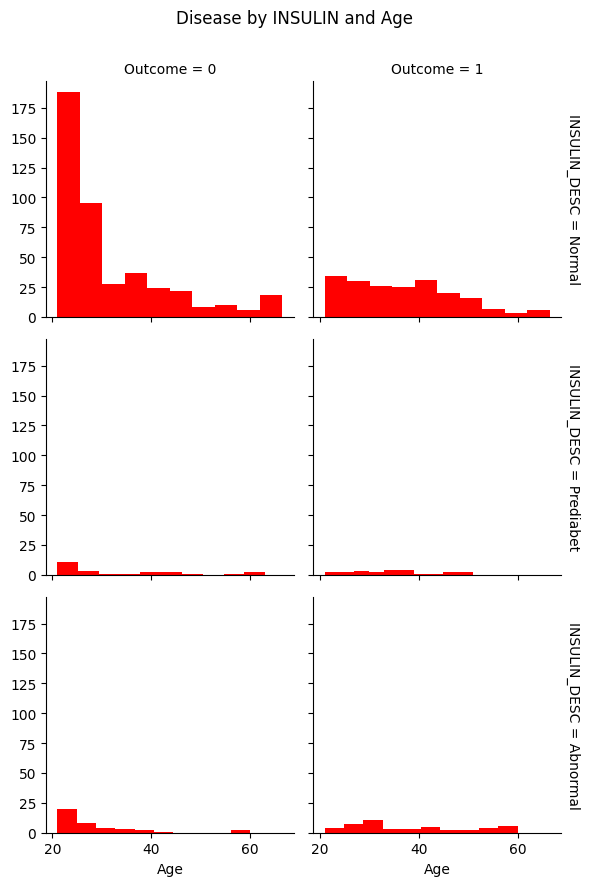

In [ ]:
g = sns.FacetGrid(df, col="Outcome", row="INSULIN_DESC", margin_titles=True)
g.map(plt.hist, "Age", color="red")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Disease by INSULIN and Age');

In [ ]:
df.groupby("Outcome")["DiabetesPedigreeFunction"].mean()

Outcome
0    0.420264
1    0.531022
Name: DiabetesPedigreeFunction, dtype: float64

In [ ]:
df.groupby("NEW_BMI")["Glucose"].mean()

NEW_BMI
ExtObese       128.447581
Normal         109.127451
Obese          123.923404
Overweight     117.000000
Underweight     95.250000
Name: Glucose, dtype: float64

In [ ]:
df.groupby(["Age","Outcome"]).agg({"BloodPressure":"mean"}).unstack()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


BloodPressure           
Outcome             0          1
Age                             
21.0        66.310345  70.800000
22.0        63.885246  72.363636
23.0        66.645161  69.000000
24.0        66.973684  64.125000
25.0        61.441176  65.357143
26.0        66.520000  65.875000
27.0        74.625000  72.625000
28.0        71.920000  66.300000
29.0        71.125000  70.076923
30.0        73.600000  54.666667
31.0        64.090909  72.692308
32.0        71.142857  73.111111
33.0        63.857143  67.400000
34.0        77.000000  66.500000
35.0        75.200000  76.000000
36.0        73.333333  70.100000
37.0        72.692308  88.166667
38.0        81.000000  68.700000
39.0        74.666667  66.666667
40.0        73.428571  70.166667
41.0        68.444444  72.384615
42.0        71.545455  76.285714
43.0        66.000000  80.727273
44.0        65.666667  72.000000
45.0        81.428571  84.500000
46.0        77.666667  74.571429
47.0        92.000000  71.500000
48.0        78.000000  80.000000
49.0        78.000000  83.666667
50.0        85.333333  74.000000
51.0        88.666667  82.000000
52.0        70.000000  83.142857
53.0        75.000000  80.000000
54.0        88.000000  89.250000
55.0        70.333333  70.000000
56.0        72.000000  78.500000
57.0        77.000000  76.000000
58.0        73.500000  84.666667
59.0        84.000000  69.000000
60.0        86.666667  70.000000
61.0        60.000000  92.000000
62.0        66.000000  77.000000
63.0        78.000000        NaN
64.0        78.000000        NaN
65.0        78.333333        NaN
66.0        81.000000  91.000000
66.5        70.428571  80.000000

**Encoding Operations**

In [ ]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [ ]:
ohe_cols


['NEW_AGE_CAT', 'NEW_Pressure', 'NEW_BMI', 'INSULIN_DESC']

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
df = one_hot_encoder(df,ohe_cols)

**Standardization**

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

df.head()
df.shape

(768, 20)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_AGE_CAT_MiddleYoung,NEW_AGE_CAT_Old,NEW_Pressure_Phase_1,NEW_Pressure_Phase_2,NEW_Pressure_Prehiper,NEW_BMI_Normal,NEW_BMI_Obese,NEW_BMI_Overweight,NEW_BMI_Underweight,INSULIN_DESC_Normal,INSULIN_DESC_Prediabet
0,0.647150,0.866045,0.092691,0.914986,-0.168350,0.181092,0.588927,1.445691,1,False,True,False,False,False,False,True,False,False,True,False
1,-0.848970,-1.205066,-0.330201,0.536065,-0.168350,-0.869465,-0.378101,-0.189304,0,True,False,False,False,False,False,False,True,False,True,False
2,1.245598,2.016662,-0.471166,-1.295388,-0.168350,-1.364728,0.746595,-0.103252,1,True,False,False,False,False,True,False,False,False,True,False
3,-0.848970,-1.073567,-0.330201,0.157144,-0.641503,-0.644346,-1.022787,-1.049828,0,False,False,False,False,False,False,False,True,False,True,False
4,-1.148194,0.504422,-2.162737,0.914986,0.487959,1.606849,2.596563,-0.017199,1,True,False,False,False,False,False,False,False,False,False,True


**Create Model**

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7835497835497836

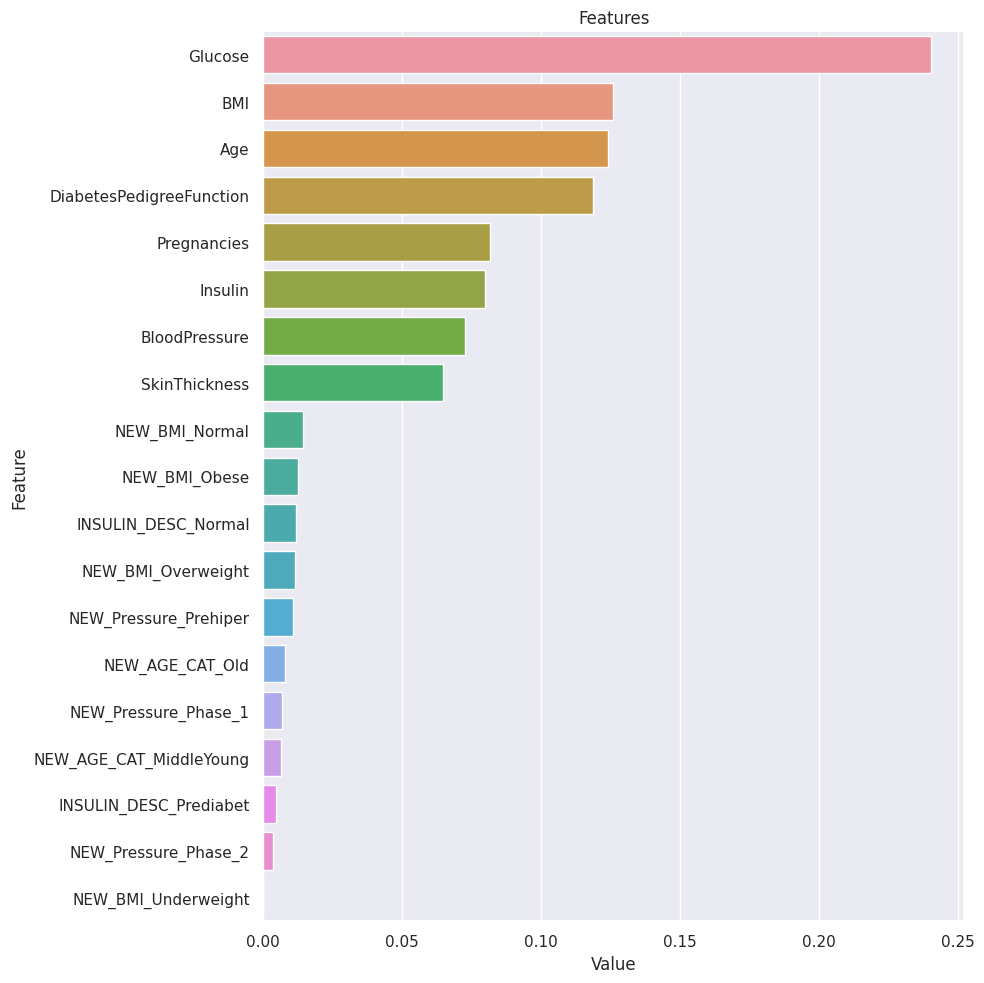

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)

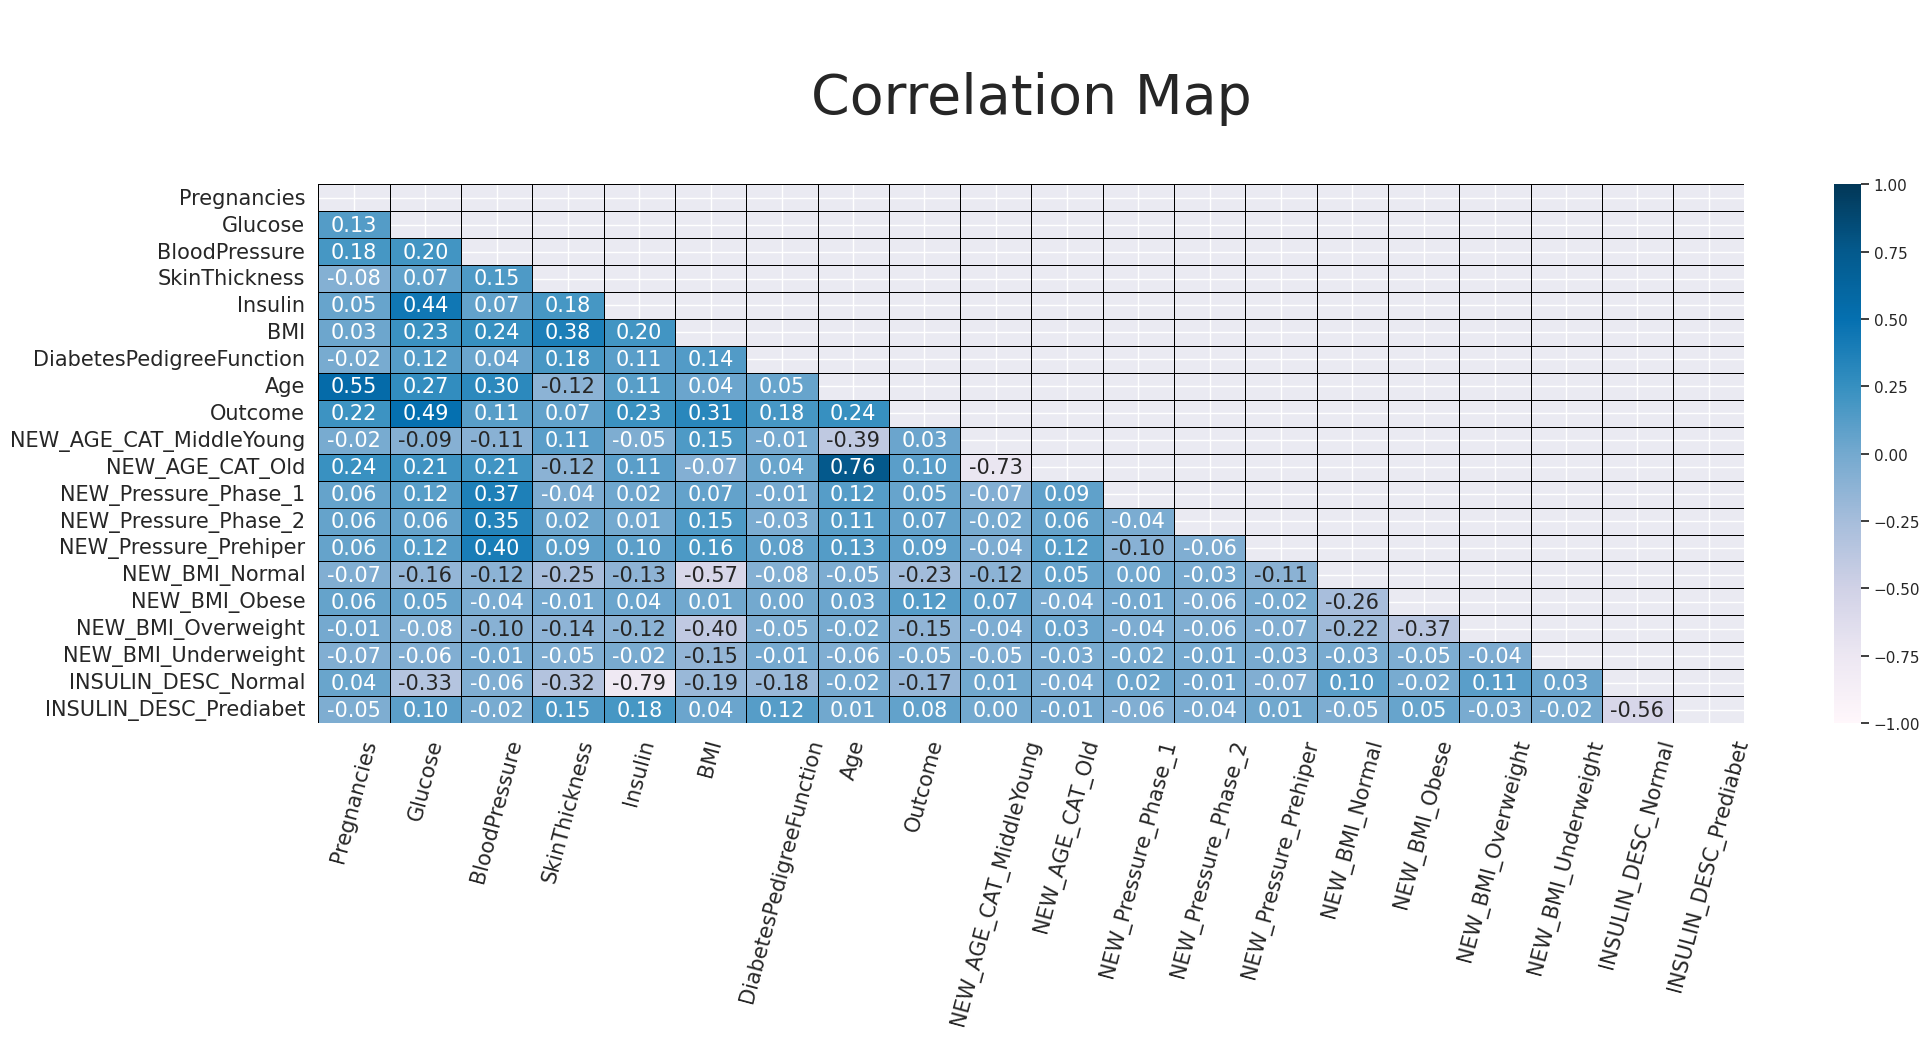

In [ ]:
def corr_map(df):
    mtx = np.triu(df.corr())
    f,ax=plt.subplots(figsize = (23,7))
    sns.heatmap(df.corr(),
                annot= True,
                fmt = ".2f",
                ax=ax,
                vmin = -1,
                vmax = 1,
                cmap = "PuBu",
                mask = mtx,
                linewidth = 0.4,
                linecolor = "black",
                annot_kws={"size": 15})
    plt.yticks(rotation=0,size=15)
    plt.xticks(rotation=75,size=15)
    plt.title('\nCorrelation Map\n', size = 40)
    plt.show()
    
corr_map(df)